In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rounding = "round"):
    in_feature = 1024
    out_feature = 1024
    bias = True

    input = (torch.rand(256, in_feature) - 0.5).to(device)

    fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
    fc_o = fc(input)
    
    ufc_err_min_list = []
    ufc_err_max_list = []
    ufc_err_mean_list = []
    ufc_err_std_list = []
    
    ofc_err_min_list = []
    ofc_err_max_list = []
    ofc_err_mean_list = []
    ofc_err_std_list = []
    
    ifc_err_min_list = []
    ifc_err_max_list = []
    ifc_err_mean_list = []
    ifc_err_std_list = []
    
    x_label = []
    
    for bitwidth in range(6, 13): 
        cycle = 2**(bitwidth-1)

        ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
        ufc_o = ufc(input)
        
        ofc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res="output", more_res="input", rounding=rounding).to(device)
        ofc_o = ofc(input)

        ifc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res="input",  more_res="input", rounding=rounding).to(device)
        ifc_o = ifc(input)
        
        ufc_err = (ufc_o - fc_o)
        ofc_err = (ofc_o - fc_o)
        ifc_err = (ifc_o - fc_o)
        
        ufc_err_min_list.append(ufc_err.min().item())
        ufc_err_max_list.append(ufc_err.max().item())
        ufc_err_mean_list.append(ufc_err.abs().mean().item())
        ufc_err_std_list.append(ufc_err.std().item())
        
        ofc_err_min_list.append(ofc_err.min().item())
        ofc_err_max_list.append(ofc_err.max().item())
        ofc_err_mean_list.append(ofc_err.abs().mean().item())
        ofc_err_std_list.append(ofc_err.std().item())
        
        ifc_err_min_list.append(ifc_err.min().item())
        ifc_err_max_list.append(ifc_err.max().item())
        ifc_err_mean_list.append(ifc_err.abs().mean().item())
        ifc_err_std_list.append(ifc_err.std().item())
        
        x_label.append(2**(bitwidth-1))
    return ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label


In [5]:
rounding = "round"
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label = test(rounding)
# print(ufc_err_min_list)
# print(ufc_err_max_list)
print(ufc_err_mean_list)
print(ufc_err_std_list)
print()

# print(ofc_err_min_list)
# print(ofc_err_max_list)
print(ofc_err_mean_list)
print(ofc_err_std_list)
print()

# print(ifc_err_min_list)
# print(ifc_err_max_list)
print(ifc_err_mean_list)
print(ifc_err_std_list)
print()

print(x_label)

[0.013263525441288948, 0.006781160831451416, 0.0034504770301282406, 0.0017619167920202017, 0.0008952602511271834, 0.0004570038872770965, 0.00023587299801874906]
[0.016625920310616493, 0.008492778986692429, 0.004326240625232458, 0.0022080971393734217, 0.0011224643094465137, 0.000572834222111851, 0.00029536348301917315]

[0.027769744396209717, 0.021553924307227135, 0.012821121141314507, 0.010038068518042564, 0.006150645203888416, 0.004842484835535288, 0.00300179747864604]
[0.03457939252257347, 0.026988286525011063, 0.01606983318924904, 0.0125908013433218, 0.007707641925662756, 0.006064299028366804, 0.003761305008083582]

[0.00300179747864604, 0.0014876647619530559, 0.0007412200793623924, 0.00037159956991672516, 0.00019055283337365836, 0.00010419799946248531, 3.685482806758955e-05]
[0.003761305008083582, 0.001865885453298688, 0.0009289734298363328, 0.00046560136252082884, 0.00023890711599960923, 0.0001305612677242607, 4.6202530938899145e-05]

[32, 64, 128, 256, 512, 1024, 2048]


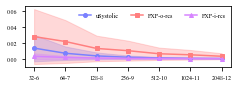

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1.2
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)

means2 = np.array(ofc_err_mean_list)
stds2 = np.array(ofc_err_std_list)
mins2 = np.array(ofc_err_min_list)
maxs2 = np.array(ofc_err_max_list)

means3 = np.array(ifc_err_mean_list)
stds3 = np.array(ifc_err_std_list)
mins3 = np.array(ifc_err_min_list)
maxs3 = np.array(ifc_err_max_list)

x_label = ['32-6', '64-7', '128-8', '256-9', '512-10', '1024-11', '2048-12']

width = 0.20
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# ax.bar(x-width, means1, width, yerr=stds1, align='center', alpha=1, capsize=3, color="#7A81FF", label="uSystolic")
# ax.bar(x,       means2, width, yerr=stds2, align='center', alpha=1, capsize=3, color="#FF7F7F", label="FXP-o")
# ax.bar(x+width, means3, width, yerr=stds3, align='center', alpha=1, capsize=3, color="#D783FF", label="FXP-i")


# ax.errorbar(x-width, means1, yerr=stds1, capsize=3, color="#7A81FF", label="uSystolic", fmt="-o", xuplims=True)
# ax.errorbar(x,       means2, yerr=stds2, capsize=3, color="#FF7F7F", label="FXP-o", fmt="-x", xuplims=True)
# ax.errorbar(x+width, means3, yerr=stds3, capsize=3, color="#D783FF", label="FXP-i", fmt="-*", xuplims=True)


ax.plot(x, means1, "-o", label="uSystolic", color="#7A81FF", ms=4)
ax.fill_between(x, means1-stds1, means1+stds1, alpha=0.3, color="#7A81FF")

ax.plot(x, means2, "-s", label="FXP-o-res",     color="#FF7F7F", ms=4)
ax.fill_between(x, means2-stds2, means2+stds2, alpha=0.3, color="#FF7F7F")

ax.plot(x, means3, "-^", label="FXP-i-res",     color="#D783FF", ms=4)
ax.fill_between(x, means3-stds3, means3+stds3, alpha=0.3, color="#D783FF")

ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yscale('linear')
# ax.set_ylim(0, 0.99)
# ax.set_yticks([0, 10**(-7), 10**(-5), 10**(-3), 10**(-1)])
# ax.set_yticklabels(["0", "1e-7", "1e-5", "1e-3", "1e-1"])
ax.legend(loc="upper right", ncol=3, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare.pdf", bbox_inches='tight', dpi=my_dpi)
